# Introduction

Most of the post-processing material presented here is written in python, and makes extensive use of the numpy package for rapid computation on large data arrays.
Here we show two important basics of python/numpy in the context of investigating your COMPAS simulation.

## Material

### [1. Inspecting the data ](#1.-Inspecting-the-data)
Look at the data to see which parameters are available and check that it matches expectations.

### [2. Slicing the data ](#2.-Slicing-the-data)
Select specific systems and their parameters using seeds.

### [3. Visualizing the data ](#3.-Visualizing-the-data)
Binning and visualising your data.

### For the following sections, you will need to have the following packages installed.
### `numpy, h5py, time, matplotlib`

In [75]:
#python libraries
import os, sys
import numpy as np               # for handling arrays
import h5py as h5                # for reading the COMPAS data
import time                      # for finding computation time
import matplotlib.pyplot as plt  #for plotting

# Import COMPAS specific scripts
compasRootDir = os.environ['COMPAS_ROOT_DIR'] 
sys.path.append(compasRootDir + 'postProcessing/PythonScripts')
from compasUtils import printCompasDetails, getEventHistory, getEventStrings

# Choose an output hdf5 file to work with
pathToData = 'COMPAS_Output_tutorial.h5'

# This is known as an ipython magic command, and allows plots to be produced within the notebook
%matplotlib inline

# 1. Inspecting the data

Often the first thing you want to do with new data is simply to look at it! Getting familiar with the data, including available parameters, size of the data file, etc. will help to inform how best to proceed with the analysis. We provide several useful functions for inspecting the data, `printCompasDetails`, `getEventHistory`, and `getEventStrings`.

--

If you do not already have a COMPAS_Output.h5 ready, see Section 1 [Working With HDF5](./WorkingWithHDF5.py) on how to create your own output file, or download some data from our [Zenodo database](https://zenodo.org/communities/compas/?page=1&size=20).

*Note:* These cells may take a long time if you test them on large datasets.

In [76]:
Data  = h5.File(pathToData)
print(list(Data.keys()))

['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Run_Details']


The output above represents the event categories available from the particular run. If you used the output produced in the previous tutorial, you should see `['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Run_Details']`. Note that for smaller runs which do not produce any of a particular type of output, the output category will not be created. 

Brief description of the categories:
- 'BSE_System_Parameters': Initial state of the binary
- 'BSE_RLOF': Any mass transfer events that occured within the binary
- 'BSE_Common_Envelopes': If any of the mass transfer events were unstable, details will be included here.
- 'BSE_Supernovae': Parameters and outcome of any supernovae that occured in the binary
- 'BSE_Double_Compact_Objects': Includes key information of all binaries which end their lives as an intact pair of compact obects (either neutron stars or black holes)
- 'Run_Details': Information on the input settings supplied to the Compas run

To extract the data from these categories, we use the following syntax

In [77]:
SPs = Data['BSE_System_Parameters']
MTs = Data['BSE_RLOF']
CEs = Data['BSE_Common_Envelopes']
SNe = Data['BSE_Supernovae']
DCs = Data['BSE_Double_Compact_Objects']

Each of these is a dictionary mapping parameter names (keys) to an array of values

In [78]:
print(SPs.keys())

<KeysViewHDF5 ['Add_Options_To_SysParms', 'Allow_MS_To_Survive_CE', 'Allow_RLOF@Birth', 'Allow_Touching@Birth', 'BB_Mass_xFer_Stblty_Prscrptn', 'BH_Kicks', 'CE_Alpha', 'CE_Alpha_Thermal', 'CE_Lambda', 'CE_Lambda_Multiplier', 'CE_Lambda_Prscrptn', 'CE_Mass_Accr_Constant', 'CE_Mass_Accr_Max', 'CE_Mass_Accr_Min', 'CE_Mass_Accr_Prscrptn', 'CE_Recomb_Enrgy_Dnsty', 'CE_Slope_Kruckow', 'CHE_Mode', 'CH_on_MS(1)', 'CH_on_MS(2)', 'Check_Photon_Tiring_Limit', 'Circularise@MT', 'Conserve_AngMom@Circ', 'Cool_WindMassLoss_Multipl', 'Eccentricity', 'Eccentricity@ZAMS', 'Eccentricity_Dstrbtn', 'Eccentricity_Dstrbtn_Max', 'Eccentricity_Dstrbtn_Min', 'Eddington_Accr_Factor', 'Envelope_State_Prscrptn', 'Equilibrated_At_Birth', 'Error', 'Evolution_Mode', 'Fryer_SN_Engine', 'Initial_Mass', 'Initial_Mass(1)', 'Initial_Mass(2)', 'Initial_Mass_Func_Max', 'Initial_Mass_Func_Min', 'Initial_Mass_Func_Power', 'Initial_Mass_Function', 'Kick_Direction_Dstrbtn', 'Kick_Direction_Power', 'Kick_Magnitude', 'Kick_Magnit

One of the most important parameters in the COMPAS output is the system seed. The seed represents the unique identifier to a specific system in a simulation. It is also used as the seed value in random number generation, which is useful when trying to reproduce a given system identically. 

If we want to view, say, the random seeds in the system parameters file, we run

In [79]:
seedsSP = SPs['SEED'][()]
print(seedsSP)

[1636090318 1636090389 1636091116     101048     102660]


### printCompasDetails

This is useful for extracting the arrays of single parameters, but for a more convenient view of the whole system parameters file, we can use the `printCompasDetails` function.

In [80]:
printCompasDetails(SPs) # Note - the output of this is a pandas dataframe

SEED,(units),1636090318,1636090389,1636091116,101048,102660
Add_Options_To_SysParms,-,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Allow_MS_To_Survive_CE,Flag,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Allow_RLOF@Birth,Flag,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Allow_Touching@Birth,Flag,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
BB_Mass_xFer_Stblty_Prscrptn,-,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
BH_Kicks,-,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
CE_Alpha,-,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CE_Alpha_Thermal,-,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CE_Lambda,-,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01
CE_Lambda_Multiplier,-,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


`PrintCompasDetails` optionally also takes seeds as arguments, to focus on specific systems.

In [81]:
seedsMT = MTs['SEED'][()]
firstThreeUniqueSeeds = np.unique(seedsMT)[0:3]
print("Look at these seeds: ", firstThreeUniqueSeeds)
printCompasDetails(MTs, firstThreeUniqueSeeds)

Look at these seeds:  [    101048     102660 1636090318]


SEED,(units),1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,...,1636090318,1636090318,1636090318,1636090318,1636090318,101048,101048,101048,102660,102660
CEE>MT,State,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
Eccentricity<MT,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.743907,0.000000,0.707907,0.000000,0.000000,0.859918
Eccentricity>MT,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.743907,0.000000,0.000000,0.000000,0.295882,0.000000,0.000000
MT_Event_Counter,Count,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,29.000000,30.000000,31.000000,32.000000,33.000000,1.000000,2.000000,3.000000,1.000000,2.000000
Mass(1)<MT,Msol,11.773666,3.943185,4.952215,4.957205,4.957273,4.957274,4.957274,4.957275,4.957275,...,4.957279,4.957279,4.957279,4.957279,1.360533,23.939714,2.008319,2.008319,25.483363,2.155738
Mass(1)>MT,Msol,3.943185,4.952215,4.957205,4.957273,4.957274,4.957274,4.957275,4.957275,4.957275,...,4.957279,4.957279,4.957279,1.360533,1.360533,7.053737,2.008319,2.008356,7.681503,2.155738
Mass(2)<MT,Msol,2.403020,2.403020,1.393990,1.389000,1.388932,1.388931,1.388931,1.388930,1.388930,...,1.388926,1.388926,1.388926,1.388925,1.388925,15.378674,20.247173,4.779758,16.504957,20.690239
Mass(2)>MT,Msol,2.403020,1.393990,1.389000,1.388932,1.388931,1.388931,1.388930,1.388930,1.388930,...,1.388926,1.388926,1.388925,1.388925,1.388925,20.692673,5.688526,1.587026,21.164807,5.868991
RLOF(1)<MT,Event,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RLOF(1)>MT,State,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000


### getEventHistory

Often, it is useful to quickly retrieve an overview of the event history of a binary, including all mass transfer, common envelope, and supernova events. For this, we use `getEventHistory`

In [82]:
seeds, events = getEventHistory(Data)

for ii, seed in enumerate(seeds):
    print(seed, events[ii])

1636090318 []
1636090389 []
1636091116 []
101048 [('MT', 7.252028833917178, 2, 1, True, False, False), ('SN', 8.223359358765522, 8, 13, 1, False), ('MT', 12.304916903390055, 13, 2, False, True, True), ('MT', 13.459891998705004, 13, 8, False, True, False), ('SN', 13.459891998705004, 8, 13, 2, False)]
102660 [('MT', 6.795882556458199, 2, 1, True, False, False), ('SN', 7.702682726277025, 8, 13, 1, False), ('MT', 11.419295515325874, 13, 2, False, True, True), ('SN', 12.561084237007242, 8, 13, 2, False)]


`getEventHistory` takes the h5file as input, and returns an array of the seeds processed as well as the major events for that seed. The format for events depends on the event type. Currently, we only include supernova and mass transfer events, but mass transfer events include a flag for whether the system underwent CEE.

- For MT events, it is ('MT', time, stellarType1, stellarType2, isRlof1, isRlof2, isCEE)
- For SN events, it is ('SN', time, stellarTypeProgenitor, stellarTypeRemnant, whichIsProgenitor, isUnbound)

There is also an optional argument `exclude_null` which defaults to False. If True, it will skip systems which undergo no events of interest (which may speed up large runs).

A useful function that builds off of `getEventHistory` is `getEventStrings`, which collects the event information into a succint string, which may be easier to read (once you get used to the syntax).

The syntax for the event strings takes the following convention:
    
- For MT events:
    - P>S, P<S, or P=S
    - where P is primary type, S is secondary type, and >, < is RLOF (1->2 or 1<-2) or = for CEE

- For SN events:
    - P\*SR for star1 the SN progenitor, or 
    - R\*SP for star2 the SN progenitor,
    - where P is progenitor type, R is remnant type, 
      S is state (I for intact, U for unbound)

Event strings for the same seed are ordered chronologically and separated by the undesrcore character `_`


In [83]:
eventStrings = getEventStrings(allEvents=events)
for ii in range(5):
    print(seeds[ii], eventStrings[ii])

1636090318 NA
1636090389 NA
1636091116 NA
101048 2>1_8*I13_13=2_13<8_13*I8
102660 2>1_8*I13_13=2_13*I8


# 2. Slicing the data

Since the random seed is unique and constant for a given binary, the properties and events of the binary system can be recovered by looking at its seed across different output categories. 

Here we introduce the basics of manipulating the data using the seeds. We provide an example on how we get the initial parameters of systems that ended up forming double compact objects.

Naively, we might try to use For Loops with Conditions to extract systems of interest to a list. However, this can potentially be computationally expensive.

Here we present a method to more efficiently 'slice' the data using numpy and boolean masks. These are slightly more involved but are computationally quick and use intuitive logic.

## Question: What were the initial total masses of the double compact objects?

In [84]:
def calculateTotalMassesNaive(pathData=None):
    Data  = h5.File(pathToData)
    
    totalMasses = []
    
    # Retrive the categories
    SPs = Data['BSE_System_Parameters']
    DCs = Data['BSE_Double_Compact_Objects']
    
    # For syntax see section 1 
    
    # Extract parameters of interest
    seedsDC       = DCs['SEED'][()]
    seedsSP       = SPs['SEED'][()]
    m1Zams        = SPs['Mass@ZAMS(1)'][()]
    m2Zams        = SPs['Mass@ZAMS(2)'][()]

    for dcSeed in seedsDC:
        for seedIndex in range(len(seedsSP)):
            spSeed = seedsSP[seedIndex]
            if spSeed == dcSeed:
                m1 = m1Zams[seedIndex]
                m2 = m2Zams[seedIndex]
                mTot = m1 + m2
                totalMasses.append(mTot)

    Data.close()
    return totalMasses

In [85]:
# calculate function run time
start   = time.time()
mTotOld = calculateTotalMassesNaive(pathData=pathToData)
end     = time.time()
timeDiffNaive = end-start

print('%s seconds, using for loops.' %(timeDiffNaive)) 

0.001825571060180664 seconds, using for loops.


# Optimizing the above loop

## 0 - Use built-in numpy routines

Numpy arrays can make use of a powerful library of optimization tools which allow the user to bypass computationally heavy for loops. 

For example, we can speed up the calculation of the element-wise sum of two arrays with:

In [86]:
SPs = Data['BSE_System_Parameters']

m1Zams  = SPs['Mass@ZAMS(1)'][()]
m2Zams  = SPs['Mass@ZAMS(2)'][()]
    
mTotalAllSystems  = np.add(m1Zams, m2Zams)

## 1 - Use boolean masks in a single file

Where previously we put the condition in an if statement nested within a for loop, now we again make use of boolean masks to filter out the undesired elements. 

The boolean array must have the same length as the input array.

In [87]:
# Create a boolean array from the total mass array which is True
# if the total mass of the corrresponding system is less than 40. 

maskMTotLessThan40 = (mTotalAllSystems <= 40)

**Crucially, you can apply this mask to all other columns in the same file because, by construction, they all have the same length.**

In [88]:
# seeds of systems with total mass below 40
seedsMtotBelow40 = seedsSP[maskMTotLessThan40]

Note that this works because the order of the two columns (seeds and total masses) are the same. 

For example, the total mass of the third system entry corresponds to the seed at the third system entry.

## 2 - Use seeds as masks between files

### Example 1

Before we continue it is useful to understand how the COMPAS-popsynth printing works.

Each simulated system will be initialized only once and so will have only one line in the `BSE_System_Parameters` file. However, lines in `BSE_RLOF` are created whenever a system goes through a mass transfer event, which might happen multiple times for a single system, or potentially not at all. Similarly, in the `BSE_Supernovae` file, you will find at most two lines per system, but possibly none. `BSE_Double_Compact_Objects` lines are printed only when the final system is intact and composed of either Neutron Stars or Black Holes, which is a rare event that happens at most once per system. 

For this reason, it is in general not the case that the system on line $n$ of one file corresponds will match the system on line $n$ of another file.

In order to match systems across files, we need to extract the seeds of desired systems from one file, and apply them as a mask in the other file. 

In [89]:
# Example: calculate the primary ZAMS mass of systems which become DCOs (Double Compact Objects)
seedsSP = SPs['SEED'][()]
seedsDC = DCs['SEED'][()]
m1Zams  = SPs['Mass@ZAMS(1)'][()]

# Calculate mask for which elements of seedsSP are found in seedsDC
# - see numpy.in1d documentation for details
mask = np.in1d(seedsSP, seedsDC)

print(mask)
print(seedsDC)
print(seedsSP[mask])
print(m1Zams[mask])
print("The occurence rate of DCOs is {}/{}".format(sum(mask), len(mask)))

[False  True  True  True  True]
[1636090389 1636091116     101048     102660]
[1636090389 1636091116     101048     102660]
[ 76.555207 113.445902  24.94177   26.74675 ]
The occurence rate of DCOs is 4/5


In [90]:
printCompasDetails(DCs, [1636090389, 1636091089, 1636091116])

SEED,(units),1636090389,1636091116
Coalescence_Time,Myr,447.467040,5.688494e+07
Eccentricity@DCO,-,0.346775,1.280522e-01
Mass(1),Msol,9.883289,1.332088e+01
Mass(2),Msol,2.315392,1.332038e+01
Merges_Hubble_Time,State,1.000000,0.000000e+00
Recycled_NS(1),Event,0.000000,0.000000e+00
Recycled_NS(2),Event,0.000000,0.000000e+00
SemiMajorAxis@DCO,AU,0.027903,9.694038e-01
Stellar_Type(1),-,14.000000,1.400000e+01
Stellar_Type(2),-,13.000000,1.400000e+01


# Optimized loop

In [91]:
def calculateTotalMassesOptimized(pathData=None):
    Data  = h5.File(pathToData)
    
    totalMasses = []
        
    # Retrive the categories
    SPs = Data['BSE_System_Parameters']
    DCs = Data['BSE_Double_Compact_Objects']
    
    # For syntax see section 1 
    
    # Extract parameters of interest
    seedsDC       = DCs['SEED'][()]
    seedsSP       = SPs['SEED'][()]
    m1Zams        = SPs['Mass@ZAMS(1)'][()]
    m2Zams        = SPs['Mass@ZAMS(2)'][()]
    
    mZamsTot            = np.add(m1Zams, m2Zams)
    maskSeedsBecameDCO  = np.in1d(seedsSP, seedsDC)
    mZamsTotOfDCOs      = mZamsTot[maskSeedsBecameDCO]
    
    Data.close()
    return mZamsTotOfDCOs

In [92]:
# calculate function run time
start   = time.time()
mTotNew = calculateTotalMassesOptimized(pathData=pathToData)
end     = time.time()
timeDiffOptimized = end-start

# calculate number of Double Compact Objects
nrDCOs = len(seedsDC)

print('Compare')
print('%s seconds, using For Loops.'     %(timeDiffNaive)) 
print('%s seconds, using Optimizations.' %(timeDiffOptimized)) 
print('Using %s DCO systems'             %(nrDCOs))

Compare
0.001825571060180664 seconds, using For Loops.
0.0031783580780029297 seconds, using Optimizations.
Using 4 DCO systems


*Note:* The time difference will depend heavily on the number of systems under investigation, as well as the number of bypassed For Loops. If you used the path to the pre-generated tutorial data set (with few, intentionally specified systems), you should see very little improvement. 

In [93]:
# Test that the two arrays are in fact identical
print(np.array_equal(mTotOld, mTotNew))

True


*Note:* the above loop can easily be expanded with more conditions.

If you do not want all the DCO initial total masses but only of the double neutron stars, then you just need to apply another mask to the seedsDC.

In [94]:
def calculateTotalMassesDNS(pathToData=None):
    Data  = h5.File(pathToData)
    
    totalMasses = []
    
    SPs = Data['BSE_System_Parameters']
    DCs = Data['BSE_Double_Compact_Objects']

    seedsDC = DCs['SEED'][()]
    stype1  = DCs['Stellar_Type(1)'][()]
    stype2  = DCs['Stellar_Type(2)'][()]

    dcMaskDNS     = (stype1 == 13) & (stype2 == 13)
    seedsDNS      = seedsDC[dcMaskDNS]
    
    # Get info from ZAMS
    seedsSP  = SPs['SEED'][()]
    m1Zams   = SPs['Mass@ZAMS(1)'][()]
    m2Zams   = SPs['Mass@ZAMS(2)'][()]
    
    mZamsTot = np.add(m1Zams, m2Zams)    
    
    spMaskDNS   = np.in1d(seedsSP, seedsDNS)
    mZamsTotDNS = mZamsTot[spMaskDNS]
    
    Data.close()
    return mZamsTotDNS

In [95]:
# calculate function run time
start   = time.time()
mTotDNS = calculateTotalMassesDNS(pathToData=pathToData)
end     = time.time()
timeDiffDNS = end-start

# calculate number of DNS systems
nrDNSs = len(mTotDNS)
    
print('%s seconds for all %s DNS systems.' %(timeDiffDNS, nrDNSs)) 

0.004323005676269531 seconds for all 2 DNS systems.


The `printCompasDetails` function can also optionally take a mask as argument. This is especially useful for those output categories which have multiple events for a single seed. Using both seeds and mask inputs can help to extract a specifc type of event from several for the given seeds.

The mask array must have the same length as the data arrays for the given category.

In [96]:
# Example: Want to investigate CEE events for seed 1636090318
printCompasDetails(MTs, 1636090318)

SEED,(units),1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,...,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318,1636090318
CEE>MT,State,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Eccentricity<MT,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.743907
Eccentricity>MT,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.743907,0.000000
MT_Event_Counter,Count,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000,31.000000,32.000000,33.000000
Mass(1)<MT,Msol,11.773666,3.943185,4.952215,4.957205,4.957273,4.957274,4.957274,4.957275,4.957275,...,4.957278,4.957278,4.957279,4.957279,4.957279,4.957279,4.957279,4.957279,4.957279,1.360533
Mass(1)>MT,Msol,3.943185,4.952215,4.957205,4.957273,4.957274,4.957274,4.957275,4.957275,4.957275,...,4.957278,4.957279,4.957279,4.957279,4.957279,4.957279,4.957279,4.957279,1.360533,1.360533
Mass(2)<MT,Msol,2.403020,2.403020,1.393990,1.389000,1.388932,1.388931,1.388931,1.388930,1.388930,...,1.388927,1.388927,1.388926,1.388926,1.388926,1.388926,1.388926,1.388926,1.388925,1.388925
Mass(2)>MT,Msol,2.403020,1.393990,1.389000,1.388932,1.388931,1.388931,1.388930,1.388930,1.388930,...,1.388927,1.388926,1.388926,1.388926,1.388926,1.388926,1.388926,1.388925,1.388925,1.388925
RLOF(1)<MT,Event,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RLOF(1)>MT,State,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


There is too much information here to be useful in this case, so we apply a mask to filter out events we're not interested in

In [97]:
maskCEE = MTs['CEE>MT'][()] == 1 # systems which undergo Common Envelope Evolution
printCompasDetails(MTs, 1636090318, mask=maskCEE)

SEED,(units),1636090318,1636090318
CEE>MT,State,1.000000,1.000000
Eccentricity<MT,-,0.000000,0.743907
Eccentricity>MT,-,0.000000,0.000000
MT_Event_Counter,Count,1.000000,33.000000
Mass(1)<MT,Msol,11.773666,1.360533
Mass(1)>MT,Msol,3.943185,1.360533
Mass(2)<MT,Msol,2.403020,1.388925
Mass(2)>MT,Msol,2.403020,1.388925
RLOF(1)<MT,Event,0.000000,0.000000
RLOF(1)>MT,State,1.000000,0.000000


### Example 2

The previous example uses the fact that both SystemParameters and DoubleCompactObjects only print at most one line per system. However, as mentioned above, events such as supernovae or common envelopes might happen multiple times to a given system, and as a result there would be multiple occurences of a given seed in the relevant file. 

To account for this, we will need to modify the previous method. Consider again the 4 seeds of the previous example. Both 2 and 4 formed a DCO and hence both stars in these binaries went SN. Seeds 1 and 3 are low mass stars hence they did not go SN. (Note that we do not specify the companion masses for any of these systems, but for simplicity we assume that the companions to 1 and 3 are also sufficiently low mass to not produce a supernova). The SN file prints one line per SN and therefore seeds 2 and 4 appear twice each.

Imagine you want the primary masses of systems that experienced at any point a core collapse supernova (CCSN). We'll reuse our mock data, with additional information about the types of SN which occured in each star. Here, PPISN refers to Pulsational Pair Instability Supernovae.

In [98]:
printCompasDetails(SNe)

SEED,(units),1636090318,1636090389,1636090389,1636091116,1636091116,101048,101048,102660,102660
Applied_Kick_Magnitude(SN),kms^-1,505.642361,45.113582,50.969609,16.648911,23.878749,76.914889,66.973808,184.916045,180.417034
ComponentSpeed(CP),kms^-1,386.014275,5.491568,128.586076,2.041058,14.649187,16.926151,177.401632,28.402032,129.864312
ComponentSpeed(SN),kms^-1,386.014275,5.491568,128.586076,2.041058,14.649187,16.926151,177.401632,28.402032,129.864312
Drawn_Kick_Magnitude(SN),kms^-1,549.417344,217.320105,50.969609,435.503588,624.150245,100.550626,66.973808,249.009476,225.718097
Eccentricity,-,0.743907,0.4113,0.346775,0.050379,0.128052,0.707907,0.295882,0.859918,0.474411
Eccentricity<SN,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Experienced_RLOF(SN),Event,1,1,1,1,1,1,1,1,1
Fallback_Fraction(SN),-,0.079675,0.79241,0.0,0.961771,0.961742,0.235063,0.0,0.257394,0.200698
Is_Hydrogen_Poor(SN),State,1,1,1,1,1,1,1,1,1
Kick_Magnitude(uK),-,1.018117,0.254925,0.059579,0.104508,0.160635,0.594548,0.083929,1.736729,0.463334


In [99]:
# Example: get the primary ZAMS masses of systems which experience 2 CCSNe before becoming a DCO

seedsSP = SPs['SEED'][()]
seedsSN = SNe['SEED'][()]
seedsDC = DCs['SEED'][()]

snType  = SNe['SN_Type(SN)'][()]
m1Zams  = SPs['Mass@ZAMS(1)'][()]

# Note: the SN_Type(SN) parameter maps integers to SN types:
snTypeDict = {
    1: 'CCSN',
    2: 'ECSN',
    16: 'USSN'
} # this dictionary is illustrative, but not explicitly used here


# Determine which seeds experienced at least 1 CCSN
maskCCSN  = snType == 1
seedsCCSN, countsCCSN = np.unique(seedsSN[maskCCSN], return_counts=True) 

# Seeds with 2 CCSNe will have a countsCCSN value of 2
seedsDoubleCCSN = seedsCCSN[countsCCSN == 2]

# Make a mask for SPs using the seeds aquired above
maskDoubleCcsnSP = np.in1d(seedsSP, seedsDoubleCCSN)
m1ZamsDoubleCcsn = m1Zams[maskDoubleCcsnSP]

print("Primary ZAMS masses for systems which undergo 2 CCSNe before becoming a DCO are: ",m1ZamsDoubleCcsn)

Primary ZAMS masses for systems which undergo 2 CCSNe before becoming a DCO are:  [113.445902  26.74675 ]


In [100]:
# Always remember to close your data file
Data.close()

# 3. Visualizing the data

Although math is the fundamental basis of physics and astrophysics, we cannot always easily convert numbers and equations into a coherent picture. Plotting is therefore a vital tool in bridging the gap between raw data and a deeper scientific understanding. 

*Disclaimer:*

There are many ways to make the same plot in matplotlib and there are many ways to bin your data. Often, there is no "best" way to display data in a plot, and the message conveyed can be heavily dependent on the context of the data as well as asthetic plotting decisions.

For example, in histograms, as we discuss below, the relatively subjective choice of bin size can significantly affect the interpretation of the results. It is important to be aware of when and how we make these choices and to try to reduce any unintended bias.

---

** Example: inspect the component masses of Double Compact Objects**

In the example below, we use the following conventions:

1 - We deliberately choose to use the matplotlib.pyplot.subplots routine even when creating a single figure (as opposed to using pyplot.plot). This is because many online forums (e.g Stackoverflow) use this syntax. Furthermore, this means you do not have to learn two different types of syntax when creating either a single or multiple panel figure.

2 - We choose to do the binning within the numpy/array environment instead of with inbuilt functions such as plt.hist / axes.hist. The reason is that you have more control over what you do, such as custom normalization (using rates, weights, pdf, etc.). It also forces you to have a deeper understanding of what you are calculating, and allows you to check intermediate steps with print statements.  Once you know how to bin your data this way you can also easily expand these routines for more complicated plots (2D binning).

**Note:** for this exercise, we recommend running your own simulation of at least 100,000 binaries in order to have a sufficient number of DCOs to have an interesting plot. We use the default tutorial data here for illustrative purposes, and because such a large data file would be too large to store on github.

# Get some data to plot

In [116]:
pathToData = 'COMPAS_Output_tutorial.h5'

Data  = h5.File(pathToData)
print(list(Data.keys()))

DCs = Data['BSE_Double_Compact_Objects']

m1 = DCs['Mass(1)'][()]
m2 = DCs['Mass(2)'][()]
mTot = np.add(m1, m2)

Data.close()

['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Run_Details']


## Plot histogram and CDF of data on left, and component mass scatter plot on the right

TypeError: sharex() missing 1 required positional argument: 'other'

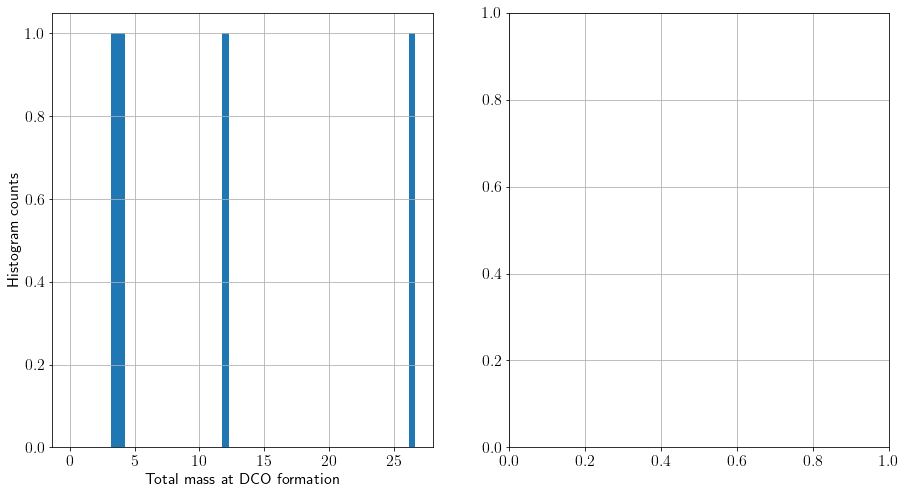

In [123]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))

# Histogram
ax1 = axes[0]
bins = np.linspace(0, max(mTot), 51) # use 50 bins, up to the maximum total DCO mass
ax1.hist(mTot, bins=bins)
ax1.set_ylabel('Histogram counts')
ax1.set_xlabel('Total mass at DCO formation')

# CDF
ax2 = ax1.sharex()
cdf_xvalues = np.cumsum(np.sort(mTot))
np.insert(cdf_xvalues, 0, 0) # insert a 0 at the front of the array
cdf_yvalues = np.linspace(0, ax.get_ylim()[1], len(cdf_xvalues))
ax2.plot(cdf_xvalues, cdf_yvalues)
ax2.set_ylabel('CDF values')

print(mTot)
print(cdf)

In [109]:
# You can use numpy to create an array with specific min, max and interval values
minMtot = 0
maxMtot = max(mTot)
nBins   = 50

# Number of bin edges is one more than number of bins
binEdges = np.linspace(minMtot, maxMtot, nBins+1)

# What is the value at the center of the bin?
# add each edge of the side of the bin and divide by 2
xvaluesHist  = (binEdges[:-1] + binEdges[1:])/2.

# What is the width of each bin? (an array in general, if the spacing is non-uniform)
binWidths = np.diff(binEdges)


### Set yvalues to the height of the bins

# Create an array of y-values for each x-value
yvalues = np.zeros(len(xvaluesHist))

# Iterate over the bins to calcuate the number of data points per bin
for iBin in range(nBins):
    mask = (mTot >= binEdges[iBin]) & (mTot < binEdges[iBin+1])
    yvalues[iBin] = np.sum(mask)

# You can of course apply any mask you like to get the desired histogram    

## Generally, you can calculate the rate per unit x (dy/dx) using
dYdXHist = np.divide(yvalues, binWidths)

# To convert your distribution to a PDF, normalize in y-values:
PDF = np.divide(yvalues, np.sum(yvalues))

# You can then multiply by, e.g, rates/weights to scale the distribution

# CDF

Sometimes we want to know what fraction of the data lies below a given value. To find this, we calculate a Cumulative Distribution Function, or CDF.

In [111]:
# Question: How many points have a value less than X? 

# Sort the values of interest
MtotSorted = np.sort(mTot)   

# These values are your xvalues 
xvaluesCDF = MtotSorted

# The CDF is a non-strictly increasing function from 0 to 1 across the range of x values.
# It should increment by 1/len(xvaluesCDF) at each x in the array, and remain constant otherwise.

# Numpy provides several functions that make this very straightforward
nDataPoints = len(xvaluesCDF)
yvalues = np.cumsum(np.ones(nDataPoints))
CDF = yvalues / nDataPoints

# A two panel plot

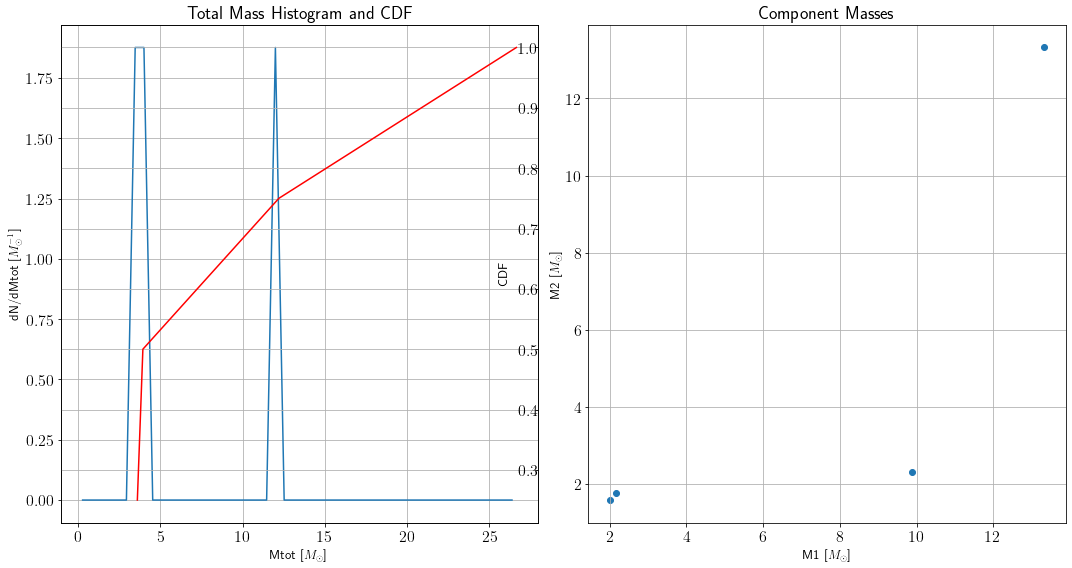

In [114]:
# For two panels side by side:
fig, axes = plt.subplots(1,2, figsize=(15,8))

# axes is an array relating to each panel
# panel1 = axes[0]
# panel2 = axes[1]

largefontsize = 18
smallfontsize = 13




### In the left panel, we want to plot the histogram and CDF overlayed
### with the same x-axis, but different y-axes

# Plot the Histogram first
histAxes = axes[0]
histAxes.plot(xvaluesHist, dYdXHist)

histAxes.set_xlabel(r'Mtot [$M_\odot$]', fontsize=smallfontsize)
histAxes.set_ylabel(r'dN/dMtot [$M_\odot^{-1}$]', fontsize=smallfontsize)

# Overlay the CDF with the same x-axis but different y-axis
cdfAxes =  axes[0].twinx()
cdfAxes.plot(xvaluesCDF, CDF, c='r')

# Dont have to do xlabel since they are the same
cdfAxes.set_ylabel('CDF', fontsize=smallfontsize, labelpad=-40)
cdfAxes.tick_params(axis='y', direction='in', pad=-20) # Adjust the CDF axis for clarity in the plot

axes[0].set_title('Total Mass Histogram and CDF', fontsize=largefontsize)




### In the right panel, we want to display a scatterplot of M1 & M2 

axes[1].scatter(m1, m2)
axes[1].set_xlabel(r'M1 [$M_\odot$]', fontsize=smallfontsize)
axes[1].set_ylabel(r'M2 [$M_\odot$]', fontsize=smallfontsize)

axes[1].set_title('Component Masses', fontsize=largefontsize)




### Clean up and display the plot

# You can force plt to pad enough between plots
# such that the labels fit
plt.tight_layout()

# If you want to save the figure, use:
#plt.savefig(pathToSave)

# To produce the plot, always remember to:
#plt.show()